# Faster R-CNN

### Import Necessary Libraries

In [2]:
!pip install torchvision
!pip install albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [3]:
import torchvision
import ast
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
from PIL import Image
import numpy as np
import json
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import zipfile
import os
import shutil
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Model

In [4]:
model = fasterrcnn_resnet50_fpn_v2(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:01<00:00, 97.8MB/s]


### Helper Functions

In [ ]:
def get_transform(train=True):
    if train:
        return A.Compose([
            A.PadIfNeeded(min_height=1024, min_width=1024, border_mode=0, value=255),
            A.AtLeastOneBBoxRandomCrop(width=512, height=512, erosion_factor=0.0),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=10, p=0.5, border_mode=0, value=255),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.PadIfNeeded(min_height=512, min_width=512, border_mode=0, value=255),
            A.CenterCrop(height=512, width=512),
            A.Normalize(mean=(0.5,), std=(0.5,)),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


## Try with Synthetically Generated Collections of Doodles

In [ ]:
def unzip_file(zip_path, extract_to):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Successfully extracted '{zip_path}' to '{extract_to}'")
    except Exception as e:
        print(f"An error occurred: {e}")

zip_file_path = '/content/drive/MyDrive/Capstone/multipleDoodles/SynthDoodleData.zip'  # Replace with the actual path
extract_directory = '/content/drive/MyDrive/Capstone/multipleDoodles/'  # Replace with the desired extraction path
unzip_file(zip_file_path, extract_directory)

Successfully extracted '/content/drive/MyDrive/Capstone/multipleDoodles/SynthDoodleData.zip' to '/content/drive/MyDrive/Capstone/multipleDoodles/'


In [ ]:
label_path = '/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/labels.csv'
with open(label_path, 'r') as file:
            all_text = file.read()

In [ ]:
resnet_df = pd.DataFrame({'image_path': images, 'word': allclasses, 'box': allboxes})
resnet_df.head()

,image_path,word,box
0,image_0010.png,"[1, 2, 11, 11, 10, 10]","[[157, 60, 285, 188], [397, 466, 559, 628], [1..."
1,image_0011.png,"[1, 2, 5, 3, 4]","[[244, 21, 345, 122], [66, 509, 173, 616], [52..."
2,image_0012.png,"[1, 4, 6]","[[378, 66, 527, 214], [167, 126, 300, 259], [3..."
3,image_0013.png,"[1, 2, 9, 11]","[[123, 201, 225, 302], [95, 461, 206, 572], [4..."
4,image_0014.png,"[1, 2]","[[325, 319, 435, 430], [176, 232, 281, 337]]"


### Set up Number of classes, feeatures, box predictor

In [ ]:
num_classes = 13
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### Set Up Dataloader

In [12]:
class DoodleDetectionDataset(Dataset):
    def __init__(self, annotations_file, image_root_dir, transforms=None):
        self.annotations = pd.read_csv(annotations_file)
        self.image_root_dir = image_root_dir
        self.transforms = transforms
        self.image_ids = self.annotations['image_path'].unique()

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.annotations[self.annotations['image_path'] == image_id]
        img_path = os.path.join(self.image_root_dir, records.iloc[0]['image_path'])
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        boxes = []
        labels = []

        for _, row in records.iterrows():
            # Modification: Handle the 'word' column as a list of labels
            label = row['word']
            if isinstance(label, str):
                label = ast.literal_eval(label) # Convert string representation to list

            # Iterate through each label in the list and convert it to an integer
            labels.extend([int(l) for l in label])

            box = row['box']
            if isinstance(box, str):
                box = ast.literal_eval(box)
            boxes.extend(box)  # Extend boxes with the list of boxes


        image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return image, target

In [13]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = DoodleDetectionDataset(
    annotations_file="/content/drive/MyDrive/Capstone/multipleDoodles/resnet_df_yflipped.csv",
    image_root_dir="/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/",
)

dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)


In [9]:
new_df = pd.read_csv('/content/drive/MyDrive/Capstone/multipleDoodles/resnet_df_yflipped.csv')
new_df.tail()

,image_path,word,box
19995,image_10005.png,"[1, 2, 5, 5, 8]","[[76, 347, 206, 476], [364, 38, 450, 124], [33..."
19996,image_10006.png,"[1, 2, 11, 9]","[[64, 40, 156, 132], [159, 273, 252, 366], [2,..."
19997,image_10007.png,[1],"[[39, 106, 175, 242]]"
19998,image_10008.png,"[1, 2, 11, 6, 3]","[[161, 425, 255, 519], [367, 14, 471, 118], [2..."
19999,image_10009.png,"[1, 3, 9, 10, 5]","[[1, 434, 118, 551], [170, 443, 276, 550], [29..."


### Load saved weights from prior training

In [14]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Capstone/fasterrcnn_synth_trained_model_flipped2.pth'))
model.train()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

## Train Model

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define optimizer and LR scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

num_epochs = 10

# Tracking
epoch_losses = []
epoch_accuracies = []
start = 2
for epoch in range(start, num_epochs):
    model.train()
    running_loss = 0.0

    for images, targets in dataloader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        running_loss += losses.item()
    torch.save(model.state_dict(), f"/content/drive/MyDrive/Capstone/fasterrcnn_synth_trained_model_flipped{epoch+1}.pth")

    lr_scheduler.step()

    avg_loss = running_loss / len(dataloader)
    epoch_losses.append(avg_loss)

    print(f"Epoch: {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")


torch.save(model.state_dict(), '/content/drive/MyDrive/Capstone/fasterrcnn_synth_trained_model.pth')
print("Training complete!")


import pandas as pd

training_metrics = pd.DataFrame({
    'epoch': list(range(1, num_epochs + 1)),
    'loss': epoch_losses,

})

training_metrics.to_csv('/content/drive/MyDrive/Capstone/fasterrcnn_synth_training_metrics.csv', index=False)
print("Loss (and accuracy) history saved to CSV.")

Epoch: 3/10, Avg Loss: 0.0325
Epoch: 4/10, Avg Loss: 0.0280
Epoch: 5/10, Avg Loss: 0.0254
Epoch: 6/10, Avg Loss: 0.0201
Epoch: 7/10, Avg Loss: 0.0187
Epoch: 8/10, Avg Loss: 0.0183
Epoch: 9/10, Avg Loss: 0.0178
Epoch: 10/10, Avg Loss: 0.0177
Training complete!


ValueError: All arrays must be of the same length

In [6]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Capstone/fasterrcnn_synth_trained_model_flipped8.pth'))
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [ ]:
new_df.head()

,image_path,word,box
0,image_0010.png,"[1, 2, 11, 11, 10, 10]","[[157, 451, 285, 579], [397, 11, 559, 173], [1..."
1,image_0011.png,"[1, 2, 5, 3, 4]","[[244, 517, 345, 618], [66, 23, 173, 130], [52..."
2,image_0012.png,"[1, 4, 6]","[[378, 425, 527, 573], [167, 380, 300, 513], [..."
3,image_0013.png,"[1, 2, 9, 11]","[[123, 337, 225, 438], [95, 67, 206, 178], [40..."
4,image_0014.png,"[1, 2]","[[325, 209, 435, 320], [176, 302, 281, 407]]"


### Show Boxes From Training Data (Not Predictions)

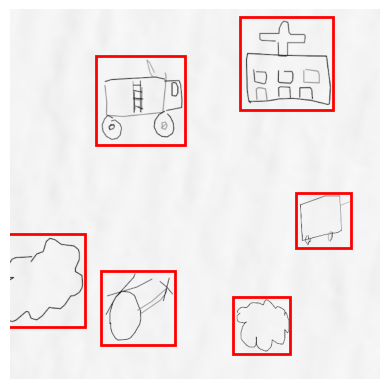

In [ ]:
resnet_df = pd.read_csv('/content/drive/MyDrive/Capstone/multipleDoodles/resnet_df.csv')

image_path = resnet_df.loc[0, 'image_path']
image = Image.open('/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/'+image_path).convert("RGB")
image = np.array(image)
orig_boxes = resnet_df.loc[0, 'box']

import json
orig_boxes = json.loads(orig_boxes.replace("'", '"'))

image = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1)

# draw boxes
fig, ax = plt.subplots(1)
ax.imshow(image.permute(1, 2, 0))

img_h = image.shape[1]  # image height (C, H, W)

for box in orig_boxes:
    x1, y1, x2, y2 = box
    y1_flipped = img_h - y2
    y2_flipped = img_h - y1
    rect = patches.Rectangle((x1, y1_flipped), x2 - x1, y2_flipped - y1_flipped,
                             linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.axis('off')
plt.show()

In [ ]:
new_df.head()

,image_path,word,box
0,image_0010.png,"[1, 2, 11, 11, 10, 10]","[[157, 451, 285, 579], [397, 11, 559, 173], [1..."
1,image_0011.png,"[1, 2, 5, 3, 4]","[[244, 517, 345, 618], [66, 23, 173, 130], [52..."
2,image_0012.png,"[1, 4, 6]","[[378, 425, 527, 573], [167, 380, 300, 513], [..."
3,image_0013.png,"[1, 2, 9, 11]","[[123, 337, 225, 438], [95, 67, 206, 178], [40..."
4,image_0014.png,"[1, 2]","[[325, 209, 435, 320], [176, 302, 281, 407]]"


## Predictions
### Predictions on Unseen Test Data (Generated from Doodles)

Time taken: 2.299528121948242 seconds


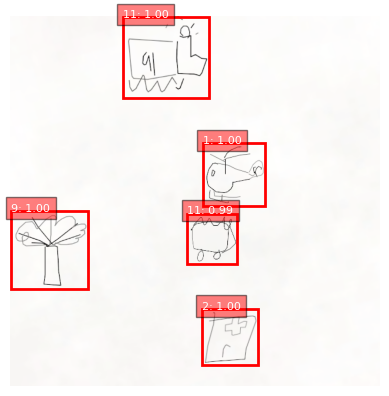

In [7]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the model
model.load_state_dict(torch.load('/content/drive/MyDrive/Capstone/fasterrcnn_synth_trained_model_flipped8.pth'))
model.eval()
model.to(device)

# time the function
import time
start_time = time.time()

# Function to predict and draw bounding boxes
def predict_and_draw(image_path, confidence_threshold=0.5):
    image = Image.open(image_path).convert("RGB")
    image = np.array(image)
    image_tensor = torch.tensor(image / 255.0, dtype=torch.float32).permute(2, 0, 1).to(device)

    with torch.no_grad():
        predictions = model([image_tensor])

    pred = predictions[0]
    boxes = pred['boxes'].cpu()
    scores = pred['scores'].cpu()
    labels = pred['labels'].cpu()

    keep = scores >= confidence_threshold
    boxes = boxes[keep]
    scores = scores[keep]
    labels = labels[keep]
    end_time = time.time()
    print(f"Time taken: {end_time - start_time} seconds")
    # Visualize
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, score, label in zip(boxes, scores, labels):
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1, f"{label}: {score:.2f}", color="white", fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()


image_path = '/content/drive/MyDrive/Capstone/image_0016.png'#'/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/' + new_df.loc[0, 'image_path']
predict_and_draw(image_path)


### Predictions on Hand-created doodles in MS Paint

Time taken: 6.4535300731658936 seconds


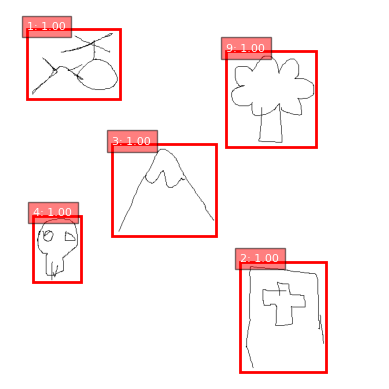

In [8]:
image_path = '/content/drive/MyDrive/Capstone/paint_test.png'#'/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/' + new_df.loc[0, 'image_path']
predict_and_draw(image_path)


### Prediction on Doodles Drawn with Pen on paper

Time taken: 540.7761270999908 seconds


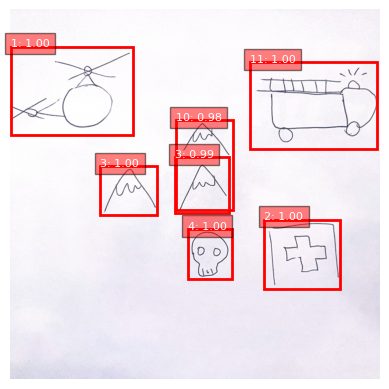

In [10]:
image_path = '/content/drive/MyDrive/Capstone/pen_test.png'#'/content/drive/MyDrive/Capstone/multipleDoodles/SynthData/' + new_df.loc[0, 'image_path']
predict_and_draw(image_path)